## Installations

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
!unzip jigsaw-toxic-comment-classification-challenge.zip

!unzip train.csv.zip

!pip install scikit-multilearn
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove.6B/
!pip install transformers

Saving kaggle.json to kaggle.json
 99% 52.0M/52.6M [00:03<00:00, 24.8MB/s]
100% 52.6M/52.6M [00:03<00:00, 17.0MB/s]
Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           
Archive:  train.csv.zip
  inflating: train.csv               
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 8.4 MB/s eta 0:00:00
--2023-05-07 20:26:43--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-07 20:26:44--  https://downloads.cs.stanford.edu/nlp/data/glove.

## Imports

In [ ]:
import pandas as pd
import nltk
# nltk.download('reuters')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import reuters
from nltk.corpus import stopwords
from nltk import PorterStemmer, WordNetLemmatizer
import re
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

import torch
from torch import optim
from torch import nn
from torch.nn.utils import clip_grad_norm_

from sklearn.metrics import hamming_loss, f1_score
from sklearn.preprocessing import MultiLabelBinarizer

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import BinaryRelevance

from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

import time
import matplotlib.pyplot as plt
import seaborn as sns
from skmultilearn.problem_transform import LabelPowerset
from sklearn.multioutput import ClassifierChain
import copy
from scipy.sparse import csr_matrix
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
import keras
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from gensim.models import Word2Vec
from sklearn.svm import SVC
import os
from typing import Tuple, List
from functools import partial

from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, BertPreTrainedModel
from sklearn.metrics import roc_auc_score


if not sys.warnoptions:
    warnings.simplefilter("ignore")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### **EDA, Preprocessing and finding embeddings of labels**


*   Below cell contains code for calculating meta data which will later be used for exploratory data analysis.

*   Then there is general preprocessing code which is applied over the text like lemmatization, etc.
*   Then there are functions which specifically preprocess the data for it to be fed to classical ML algorithms.


*   Then we have the code to find the glove and bert embeddings of the labels. These embeddings will then be used in deep learning algorithms and MAGNET.













In [ ]:
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

stemmer = SnowballStemmer("english")

def plot_len_of_sentences(text_cols):
    comment_len = text_cols.len()

    # plot the distribution of comment lengths
    plt.figure(figsize=(8,4))
    sns.histplot(comment_len, kde=False, bins=50, color="red")
    plt.xlabel("Comment Length (Number of words)", fontsize=12)
    plt.ylabel("Number of Comments", fontsize=12)
    plt.title("Distribution of comment Lengths", fontsize=12)

  print("Average comment length:",int(sum(comment_len)/len(comment_len))," characters")

def plot_bar_graph(train_df,labels,title):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_axes([0,0,1,1])
    total_count = []
    for label in labels:
        total_count.append(len(train_df[train_df[label] == 1]))
    ax.bar(labels,total_count, color=['red', 'green', 'blue', 'purple', 'orange', 'yellow'])
    for i,data in enumerate(total_count):
        plt.text(i-.25, 
                data/total_count[i]+100, 
                total_count[i], 
                fontsize=12)
    plt.title(title)
    plt.xlabel('Labels')
    plt.ylabel('Number of comments')

def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

def lemmatize(sentence):
    lemmatizer = WordNetLemmatizer()
    lemSentence = ""
    for word in sentence.split():
        lem = lemmatizer.lemmatize(word)
        lemSentence += lem
        lemSentence += " "
    lemSentence = lemSentence.strip()
    return lemSentence

def preprocess_text(train_df):
    train_df['comment_text'] = train_df['comment_text'].str.lower()
    train_df['comment_text'] = train_df['comment_text'].apply(cleanHtml)
    train_df['comment_text'] = train_df['comment_text'].apply(cleanPunc)
    train_df['comment_text'] = train_df['comment_text'].apply(keepAlpha)
    train_df['comment_text'] = train_df['comment_text'].apply(removeStopWords)
    train_df['comment_text'] = train_df['comment_text'].apply(lemmatize)
    return train_df

def sample_dataset(train_df):
    df = train_df[train_df['clean']==0]
    df = df.append(train_df[train_df['clean']==1].sample(frac=1, random_state=200).iloc[:df.shape[0],:])
    df = df.sample(frac=1,random_state=200)
    return df

#ML preprocessing
def baseline_ml_preprocessing(X_train,X_test):
    word_vectorizer = TfidfVectorizer(
        strip_accents='unicode',     
        analyzer='word',
        max_features=3000,        
        token_pattern=r'\w{1,}',    
        ngram_range=(1, 3),         
        stop_words='english',
        sublinear_tf=True)

    word_vectorizer.fit(X_train)
    ml_X_train = word_vectorizer.transform(X_train)
    ml_X_test = word_vectorizer.transform(X_test)
    return ml_X_train, ml_X_test

def Sequential_Preprocessing(X_train, X_test, y_train, y_test,max_seq_len):
    tokenizer = Tokenizer(num_words=20000,oov_token='<UNK>')
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    X_train = torch.from_numpy(pad_sequences(X_train, maxlen=max_seq_len))
    X_test = torch.from_numpy(pad_sequences(X_test, maxlen=max_seq_len))

    y_train = torch.from_numpy(y_train)
    y_test = torch.from_numpy(y_test)

    return tokenizer, X_train, y_train, X_test, y_test

def create_glove_embedding_matrix(tokenizer, glove_file_path):
    glove_embeddings = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            glove_embeddings[word] = vector

    vocab_size = len(tokenizer.index_word) + 1
    #File 300 dim expected
    embedding_dim = 300
    glove_embedding_matrix = torch.zeros(vocab_size, embedding_dim)

    unknown_words = 0
    for i in range(1, vocab_size):
        word = tokenizer.index_word[i]
        if word in glove_embeddings.keys():
            glove_embedding_matrix[i] = torch.from_numpy(glove_embeddings[word]).float()
        else:
            unknown_words += 1

    print("GloVe embedding matrix created!")
    print('Vocabulary size: {}'.format(vocab_size))
    print('Total unknown words: {}'.format(unknown_words))

    return glove_embeddings, glove_embedding_matrix

def create_glove_label_embedding(labels, glove_embeddings):
    glove_label_embedding = torch.zeros(len(labels), 300)

    for index, label in enumerate(labels):
        wrds = label.split('_')
        for l in wrds:
            if l in glove_embeddings.keys():
                glove_label_embedding[index] += torch.from_numpy(glove_embeddings[l])
        glove_label_embedding[index] /= len(wrds)

    return glove_label_embedding

def get_bert_embedding_matrix(tokenizer):
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    vocab_size = len(tokenizer.index_word)+1
    bert_embedding_matrix = torch.zeros(vocab_size, 768)


    tokens_tensor=[]
    for i in tqdm(range(1, vocab_size)):
        word = tokenizer.index_word[i]
        tokens = bert_tokenizer.encode(word,add_special_tokens=False)[0]
        tokens_tensor.append(tokens)
    batch_size = 512
    vocab_batches = [tokens_tensor[i:i+batch_size] for i in range(0, len(tokens_tensor), batch_size)]

    with torch.no_grad():
      bert_embeddings = []
      for i in tqdm(range(len(vocab_batches))):
        batch = vocab_batches[i]
        inputs = {
        'input_ids': torch.tensor([batch]),
        'attention_mask': torch.ones(len(batch)).unsqueeze(0)
        }
        outputs = bert_model(**inputs)
        batch_embeddings = outputs[0][0]
        bert_embeddings.append(batch_embeddings)
        
    bert_embedding_matrix = torch.cat(bert_embeddings, dim=0)
    return bert_embedding_matrix


#Build adjacency matrix based on Co-Occurencies label
def create_adjacency_matrix_cooccurance(data_label):
  cooccur_matrix = np.zeros((data_label.shape[1], data_label.shape[1]), dtype=float)
  for y in data_label:
      y = list(y)
      for i in range(len(y)):
          for j in range(len(y)):
            #data_label
              if y[i] == 1 and y[j] == 1:
                  cooccur_matrix[i, j] += 1
  row_sums = data_label.sum(axis=0)

  for i in range(cooccur_matrix.shape[0]):
    for j in range(cooccur_matrix.shape[0]):
      if row_sums[i]!=0:
        cooccur_matrix[i][j]=cooccur_matrix[i,j]/row_sums[i]
      else:
        cooccur_matrix[i][j]=cooccur_matrix[i,j]
  
  return cooccur_matrix


def check_accuracy(model, label_embedding, X, y):
  model.eval()
  with torch.no_grad():
    out = model(X, label_embedding)
    y_pred = torch.sigmoid(out.detach()).round().cpu()
    f1score = f1_score(y, y_pred, average='micro')
    hammingloss = hamming_loss(y, y_pred)
  return hammingloss, f1score

class dataset(Dataset):
  def __init__(self, x, y):
    self.x  = x
    self.y = y
  def __len__(self):
    return len(self.x)
  
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

def create_adjacency_matrix_xavier(data_label):
  adj_matrix = torch.empty((data_label.shape[1], data_label.shape[1]))
  adj_matrix = nn.init.xavier_uniform_(adj_matrix)
  return adj_matrix

Since most of the tweets dont contain any hateful content, we add a new column called 'clean'. If this is marked as 1, then this means that the tweet does not contain any offensive content. If clean = 1, then all other labels will be marked as 0.

In [ ]:
train_df = pd.read_csv('train.csv')
print("Data shape:",train_df.shape)
#assigning labels

#Adding new column of Clean Text
arr=[]
for i in range(train_df.shape[0]):
  if (train_df.iloc[i,2:]==0).all():
    arr.append(1)
  else:
    arr.append(0)
train_df['clean'] = pd.Series(np.asarray(arr))
labels = train_df.columns[2:]
print("Labels:",labels)

Data shape: (159571, 8)
Labels: Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate',
       'clean'],
      dtype='object')


In [ ]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


Average comment length: 394  characters


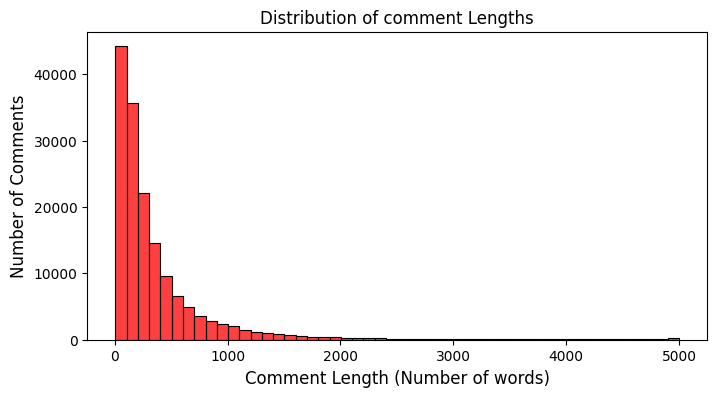

In [ ]:
plot_len_of_sentences(train_df.comment_text.str)

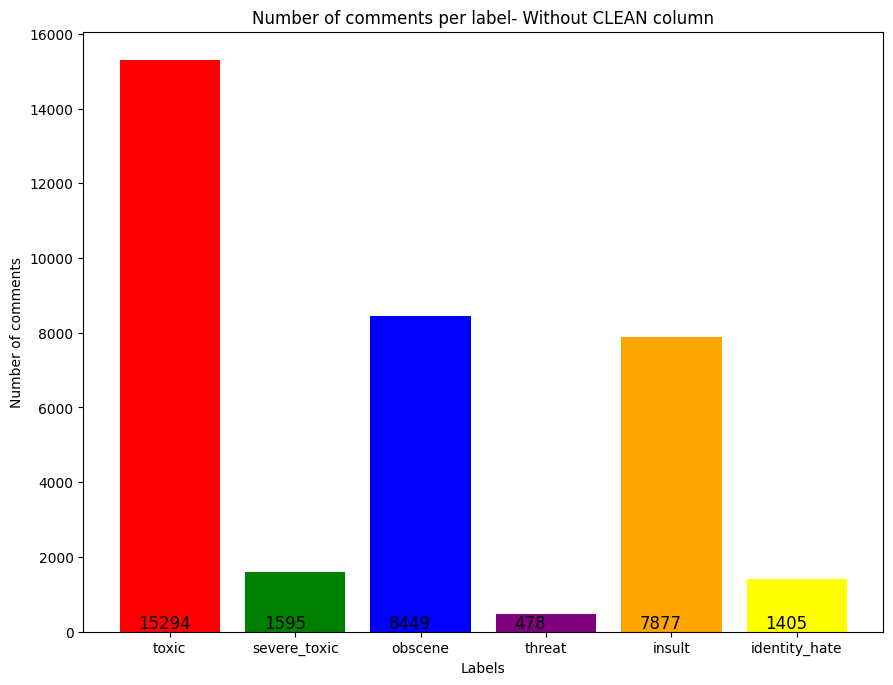

In [ ]:
#Without clean Text
plot_bar_graph(train_df,labels[:-1],'Number of comments per label- Without CLEAN column')

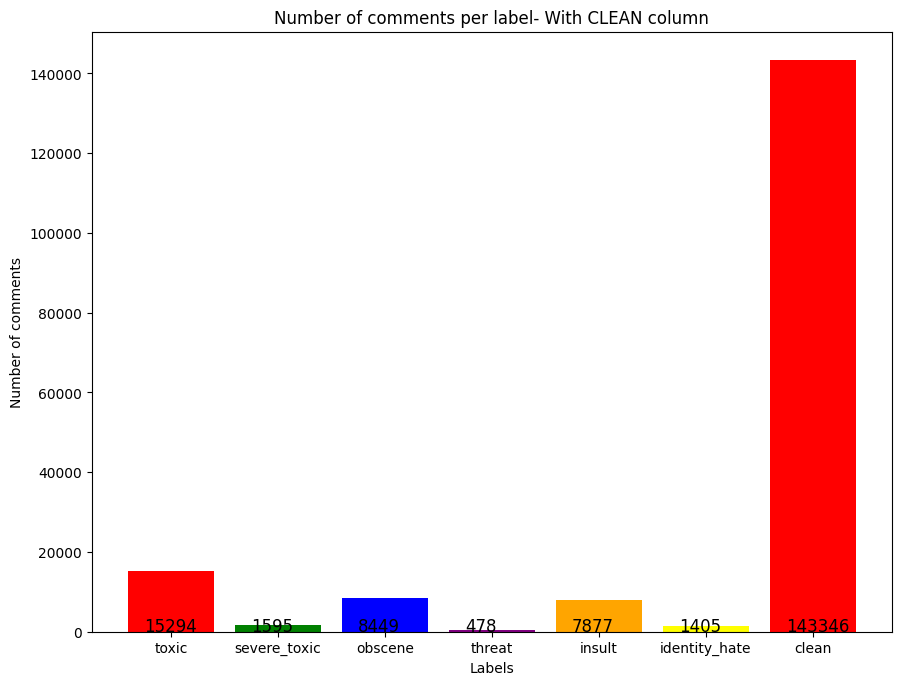

In [ ]:
#With clean Text
plot_bar_graph(train_df,labels,'Number of comments per label- With CLEAN column')

The above graph shows that most of the tweets dont contain any hate content.

In [ ]:
train_df = preprocess_text(train_df)
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,daww match background colour im seemingly stuc...,0,0,0,0,0,0,1
2,000113f07ec002fd,hey man im really trying edit war guy constant...,0,0,0,0,0,0,1
3,0001b41b1c6bb37e,cant make real suggestion improvement wondered...,0,0,0,0,0,0,1
4,0001d958c54c6e35,sir hero chance remember page thats on,0,0,0,0,0,0,1


In [ ]:
#Get sampled Data by removing Rows which create Bias
train_df = sample_dataset(train_df)
train_df.head()

<ipython-input-3-ecde23a7a0f1>:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(train_df[train_df['clean']==1].sample(frac=1, random_state=200).iloc[:df.shape[0],:])


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
134065,cd04ee4935924644,got ill start on,0,0,0,0,0,0,1
128040,acd929b3f6c5984b,barnstar anti vandalism barnstar professing lo...,0,0,0,0,0,0,1
136471,da225210fb20b417,homey yo beat u up,0,0,0,1,0,0,0
112748,5b33d2be26a63953,encouraged feedback let clear bit first versio...,0,0,0,0,0,0,1
21589,38dd995c105311e6,shes insane zealot,1,0,0,0,1,0,0


## **Removing bias from the data** 

Since majority of the tweets were not offensive, this means that the training data is quite biased. Therefore we took 16000 tweets which contained some offensive content, and an equal number of tweets which were clean.

Doing this, we ensure that our training data is not biased against a particular label.

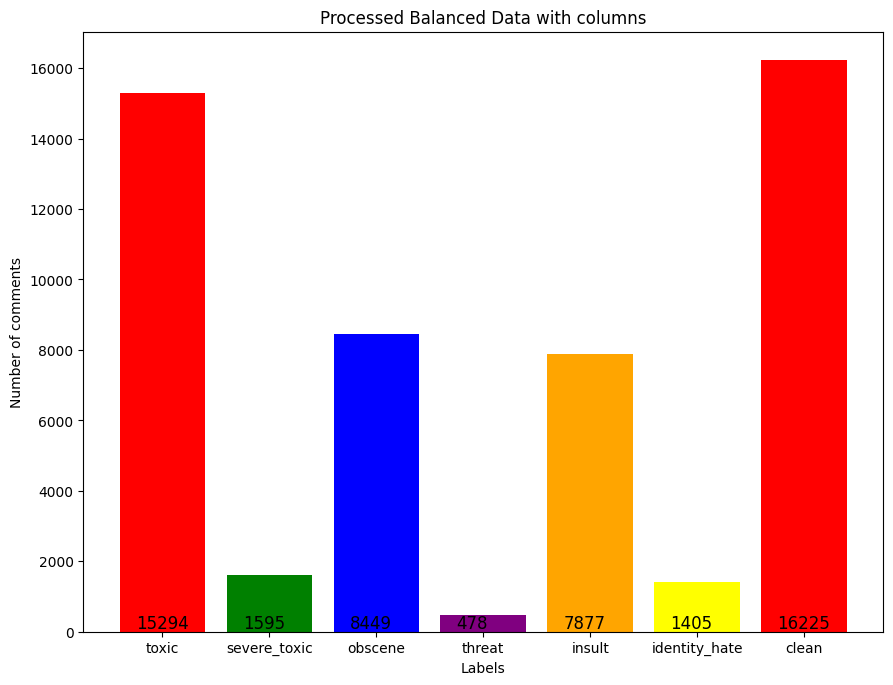

In [ ]:
#modified dataset
plot_bar_graph(train_df,labels,'Processed Balanced Data with columns')

In [ ]:
X = train_df['comment_text'].values
y = train_df.iloc[:,2:].values
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=200, stratify=y[:,-1])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

(32450,) (32450, 7)
(25960,) (6490,) (25960, 7) (6490, 7)


In [ ]:
ml_X_train, ml_X_test = baseline_ml_preprocessing(X_train,X_test)
print("X_train shape for baseline models:",ml_X_train.shape)
print("X_test shape for baseline models:",ml_X_test.shape)

X_train shape for baseline models: (25960, 3000)
X_test shape for baseline models: (6490, 3000)


**Training using classical ML algorithms**

Now we have our train and test data ready to be used in ML algorithms. The are prefixed with ml_

In [ ]:
scores_df = pd.DataFrame(columns=['model_name','micro_avg_f1_score','hamming_loss','accuracy'])

We test the following algorithms - 



*   Binary Relevance
*   Classifier Chain
*   One Vs Rest
*   Label PowerSet
*   Hierarchical SVM



In [ ]:
class HierarchicalSVM:
    def __init__(self):
        self.classifiers = {}#Dictionary to store the classifiers for each label

    def train(self, X_train, Y_train):
        num_labels = Y_train.shape[1]
        # Train the classifiers for each label
        for label_idx in range(num_labels):
            label = str(label_idx)
            Y_label = Y_train[:, label_idx]
            classifier = SVC(kernel='linear')
            classifier.fit(X_train, Y_label)
            self.classifiers[label] = classifier

    def predict(self, X_test):
        num_labels = len(self.classifiers)
        num_samples = X_test.shape[0]
        predictions = np.zeros((num_samples, num_labels))
        for label_idx, classifier in self.classifiers.items():
            label_predictions = classifier.predict(X_test)
            predictions[:, int(label_idx)] = label_predictions
        return predictions

In [ ]:
print("====================BR============================")
model = BinaryRelevance(LogisticRegression(solver='sag'))
model.fit(ml_X_train,  y_train[:,:-1])
y_pred = model.predict(ml_X_test)
arr={'model_name':'BR','micro_avg_f1_score':f1_score(y_test[:,:-1], y_pred, average="micro"),'hamming_loss':hamming_loss(y_test[:,:-1], y_pred),'accuracy':accuracy_score(y_test[:,:-1],y_pred)}
scores_df = scores_df.append(arr,ignore_index=True)
print(classification_report(y_pred,y_test[:,:-1]))

print("====================Classifier Chain============================")

model = ClassifierChain(LogisticRegression(solver='sag'))
model.fit(ml_X_train, y_train[:,:-1])
y_pred = model.predict(ml_X_test)
arr={'model_name':'Classifier_Chain','micro_avg_f1_score':f1_score(y_test[:,:-1], y_pred, average="micro"),'hamming_loss':hamming_loss(y_test[:,:-1], y_pred),'accuracy':accuracy_score(y_test[:,:-1],y_pred)}
scores_df = scores_df.append(arr,ignore_index=True)
print(classification_report(y_pred,y_test[:,:-1]))

print("====================One Vs Rest============================")

model = OneVsRestClassifier(LogisticRegression())
model.fit(ml_X_train, y_train[:,:-1])
y_pred = model.predict(ml_X_test)
arr={'model_name':'One_vs_rest','micro_avg_f1_score':f1_score(y_test[:,:-1], y_pred, average="micro"),'hamming_loss':hamming_loss(y_test[:,:-1], y_pred),'accuracy':accuracy_score(y_test[:,:-1],y_pred)}
scores_df = scores_df.append(arr,ignore_index=True)
print(classification_report(y_pred,y_test[:,:-1]))

print("====================Label PowerSet============================")
model = LabelPowerset(LogisticRegression(max_iter=1000))
model.fit(ml_X_train, y_train[:,:-1])
y_pred = model.predict(ml_X_test)
arr={'model_name':'Label_Powerset','micro_avg_f1_score':f1_score(y_test[:,:-1], y_pred, average="micro"),'hamming_loss':hamming_loss(y_test[:,:-1], y_pred),'accuracy':accuracy_score(y_test[:,:-1],y_pred)}
scores_df = scores_df.append(arr,ignore_index=True)
print(classification_report(y_pred,y_test[:,:-1]))
print("====================Hierarchical SVM============================")
model = HierarchicalSVM()
model.train(ml_X_train, y_train[:,:-1])
y_pred = model.predict(ml_X_test)
arr={'model_name':'Hierarchical_SVM','micro_avg_f1_score':f1_score(y_test[:,:-1], y_pred, average="micro"),'hamming_loss':hamming_loss(y_test[:,:-1], y_pred),'accuracy':accuracy_score(y_test[:,:-1],y_pred)}
scores_df = scores_df.append(arr,ignore_index=True)
print(classification_report(y_pred,y_test[:,:-1]))


====================BR============================


<ipython-input-16-e632f2dc34b0>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(arr,ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.84      0.89      0.86      2878
           1       0.20      0.55      0.29       108
           2       0.69      0.88      0.78      1335
           3       0.11      0.71      0.19        17
           4       0.58      0.78      0.66      1166
           5       0.26      0.69      0.37        97

   micro avg       0.68      0.85      0.76      5601
   macro avg       0.45      0.75      0.53      5601
weighted avg       0.72      0.85      0.78      5601
 samples avg       0.33      0.37      0.34      5601

====================Classifier Chain============================


<ipython-input-16-e632f2dc34b0>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(arr,ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.84      0.89      0.86      2878
           1       0.18      0.54      0.28       100
           2       0.72      0.87      0.79      1413
           3       0.10      0.69      0.18        16
           4       0.63      0.73      0.68      1349
           5       0.30      0.75      0.43       104

   micro avg       0.70      0.84      0.76      5860
   macro avg       0.46      0.74      0.53      5860
weighted avg       0.74      0.84      0.78      5860
 samples avg       0.34      0.36      0.34      5860

====================One Vs Rest============================


<ipython-input-16-e632f2dc34b0>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(arr,ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.84      0.89      0.86      2878
           1       0.20      0.55      0.29       108
           2       0.69      0.88      0.78      1335
           3       0.11      0.71      0.19        17
           4       0.58      0.78      0.66      1166
           5       0.26      0.69      0.37        97

   micro avg       0.68      0.85      0.76      5601
   macro avg       0.45      0.75      0.53      5601
weighted avg       0.72      0.85      0.78      5601
 samples avg       0.33      0.37      0.34      5601

====================Label PowerSet============================


<ipython-input-16-e632f2dc34b0>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(arr,ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.76      0.91      0.83      2550
           1       0.13      0.58      0.21        64
           2       0.62      0.88      0.73      1200
           3       0.05      0.83      0.09         6
           4       0.55      0.78      0.64      1098
           5       0.18      0.68      0.29        71

   micro avg       0.62      0.87      0.72      4989
   macro avg       0.38      0.78      0.46      4989
weighted avg       0.66      0.87      0.75      4989
 samples avg       0.29      0.34      0.30      4989

====================Hierarchical SVM============================
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2900
           1       0.06      0.71      0.11        24
           2       0.74      0.88      0.80      1426
           3       0.11      0.63      0.19        19
           4       0.63      0.76      0.69      1290
           5 

<ipython-input-16-e632f2dc34b0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(arr,ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Summarizing the results of classical ML algorithms**

In [ ]:
scores_df

,model_name,micro_avg_f1_score,hamming_loss,accuracy
0,BR,0.759005,0.077838,0.661787
1,Classifier_Chain,0.764568,0.077607,0.668259
2,One_vs_rest,0.759005,0.077838,0.661787
3,Label_Powerset,0.722106,0.085388,0.653621
4,Hierarchical_SVM,0.775302,0.073549,0.671957


In [ ]:
#DL preprocessing

In [ ]:
max_seq_len = 100
tokenizer, X_train, y_train, X_test, y_test = Sequential_Preprocessing(X_train, X_test, y_train, y_test,max_seq_len)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([25960, 100]) torch.Size([6490, 100]) torch.Size([25960, 7]) torch.Size([6490, 7])


Finding the glove and bert embeddings

In [ ]:
glove_embeddings, glove_embedding_matrix = create_glove_embedding_matrix(tokenizer,glove_file_path='glove.6B/glove.6B.300d.txt')

GloVe embedding matrix created!
Vocabulary size: 50685
Total unknown words: 16419


In [ ]:
glove_label_embeddings = create_glove_label_embedding(labels,glove_embeddings)
print(glove_label_embeddings.shape)

torch.Size([7, 300])


In [ ]:
# word2vec_model = Word2Vec.load('path/to/word2vec_model')

# word2vec_embedding = {word: word2vec_model.wv[word] for word in word2vec_model.wv.vocab}

# # Define the vocabulary size and embedding dimensions
# vocab_size = len(tokenizer.index_word)+1
# embedding_dim = word2vec_model.vector_size

# # Create the embedding matrix
# word2vec_embedding_matrix = np.zeros((vocab_size, embedding_dim))
# for i, word in enumerate(word2vec_embedding):
#     word = tokenizer.index_word[i]
#     if word in word2vec_embedding.keys():
#       word2vec_embedding_matrix[i] = word2vec_embedding[word]
#     else:
#       continue
# print("Word2Vec Embedding matrix created!")
# print(word2vec_embedding_matrix.shape)

# word2vec_label_embedding = torch.zeros(len(labels),embedding_dim)

# for index, label in enumerate(labels):
#   wrds = label.split('_')
#   for l in wrds:
#     if l in word2vec_embedding.keys():
#         word2vec_label_embedding[index] +=  torch.from_numpy(word2vec_embedding[l])
#   word2vec_label_embedding[index]=word2vec_label_embedding[index]/len(wrds) 

# print("Word2Vec label embedding:")
# print(word2vec_label_embedding)

In [ ]:
bert_embeddding_matrix = get_bert_embedding_matrix(tokenizer)
print(bert_embeddding_matrix.shape)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|██████████| 99/99 [01:55<00:00,  1.17s/it]

torch.Size([50684, 768])


In [ ]:
#Checking GPU for tensorflow
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
keras.backend.set_session(sess)
print("GPU is Available? =>",tf.test.is_gpu_available())

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU is Available? => True


In [ ]:
VOCAB_SIZE = len(tokenizer.index_word)+1
#Preparing for KERAS Model
glove_embd_mat= np.array(glove_embedding_matrix.to('cpu'))
glove_embd_mat = np.vstack((np.zeros((1, glove_embd_mat.shape[1])), glove_embd_mat))
bert_embd_mat= np.array(bert_embeddding_matrix.to('cpu').detach().numpy())
bert_embd_mat = np.vstack((np.zeros((1, bert_embd_mat.shape[1])), bert_embd_mat))

### Running deep learning algorithms

The algorithms used are - 
* BiLSTM using glove embeddings
* BiLSTM using BERT embeddings
* CNN using BERT embeddings
* CNN usin BERT embeddings

In [ ]:
print("=====================Glove BiLSTM===========================")
inp = Input(shape=(max_seq_len,))
x = Embedding(VOCAB_SIZE+1, 300, weights=[glove_embd_mat])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(7, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(np.asarray(X_train),np.asarray(y_train), batch_size=256, epochs=3)
y_pred = model.predict(np.asarray(X_test),batch_size=256, verbose=1)
y_pred= np.where(y_pred > 0.5, 1, 0)

arr={'model_name':'BiLSTM_glove','micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),'hamming_loss':hamming_loss(y_test, y_pred),'accuracy':accuracy_score(y_test,y_pred)}
scores_df = scores_df.append(arr,ignore_index=True)
print(scores_df)
print(classification_report(y_pred,y_test))


=====================Glove BiLSTM===========================
Epoch 1/3
102/102 [==============================] - 91s 828ms/step - loss: 0.3949 - accuracy: 0.6428
Epoch 2/3
102/102 [==============================] - 77s 756ms/step - loss: 0.2204 - accuracy: 0.8665
Epoch 3/3
26/26 [==============================] - 2s 45ms/step
         model_name  micro_avg_f1_score  hamming_loss  accuracy
0                BR            0.768250      0.076117  0.667180
1  Classifier_Chain            0.769028      0.076451  0.672111
2       One_vs_rest            0.765692      0.076117  0.667180
3    Label_Powerset            0.734849      0.082357  0.661941
4  Hierarchical_SVM            0.776746      0.073472  0.672265
5         CNN_glove            0.815412      0.078670  0.657473
6      BiLSTM_glove            0.828584      0.075083  0.667951
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3113
           1       0.17      0.71      0.28       

<ipython-input-55-3ae34c0b4e40>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(arr,ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("=====================Bert BiLSTM===========================")
inp = Input(shape=(max_seq_len,))
x = Embedding(VOCAB_SIZE, 768, weights=[bert_embd_mat])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(7, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(np.asarray(X_train),np.asarray(y_train), batch_size=256, epochs=4)
y_pred = model.predict(np.asarray(X_test),batch_size=256, verbose=1)
y_pred= np.where(y_pred > 0.5, 1, 0)

arr={'model_name':'BiLSTM_bert','micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),'hamming_loss':hamming_loss(y_test, y_pred),'accuracy':accuracy_score(y_test,y_pred)}
scores_df = scores_df.append(arr,ignore_index=True)
print(scores_df)
print(classification_report(y_pred,y_test))

=====================Bert BiLSTM===========================


Epoch 1/4
102/102 [==============================] - 107s 952ms/step - loss: 0.3838 - accuracy: 0.6665
Epoch 2/4
102/102 [==============================] - 93s 909ms/step - loss: 0.1867 - accuracy: 0.8998
Epoch 3/4
102/102 [==============================] - 87s 856ms/step - loss: 0.1513 - accuracy: 0.9327
Epoch 4/4
26/26 [==============================] - 2s 69ms/step
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      3027
           1       0.37      0.52      0.43       206
           2       0.83      0.84      0.83      1671
           3       0.00      0.00      0.00         0
           4       0.68      0.73      0.70      1463
           5       0.15      0.75      0.24        51
           6       0.93      0.90      0.91      3332

   micro avg       0.81      0.85      0.83      9750
   macro avg       0.55      0.66      0.57      9750
weighted avg       0.84      0.85      0.85      9750
 samples avg       0.83      0.84

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("=====================Glove CNN===========================")
inp = Input(shape=(max_seq_len,))

x = Embedding(VOCAB_SIZE+1, 300, weights=[glove_embd_mat])(inp)
x = layers.Conv1D(filters=128, kernel_size=5, activation='relu')(x)
x = GlobalMaxPool1D()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)
x = Dense(7, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(np.asarray(X_train),np.asarray(y_train), batch_size=256, epochs=3)
y_pred = model.predict(np.asarray(X_test),batch_size=256, verbose=1)
y_pred= np.where(y_pred > 0.5, 1, 0)

arr={'model_name':'CNN_glove','micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),'hamming_loss':hamming_loss(y_test, y_pred),'accuracy':accuracy_score(y_test,y_pred)}
scores_df = scores_df.append(arr,ignore_index=True)
print(scores_df)
print(classification_report(y_pred,y_test))


=====================Glove CNN===========================
Epoch 1/3
102/102 [==============================] - 32s 198ms/step - loss: 0.3643 - accuracy: 0.6813
Epoch 2/3
102/102 [==============================] - 15s 150ms/step - loss: 0.2018 - accuracy: 0.8738
Epoch 3/3
26/26 [==============================] - 0s 7ms/step
         model_name  micro_avg_f1_score  hamming_loss  accuracy
0                BR            0.768250      0.076117  0.667180
1  Classifier_Chain            0.769028      0.076451  0.672111
2       One_vs_rest            0.765692      0.076117  0.667180
3    Label_Powerset            0.734849      0.082357  0.661941
4  Hierarchical_SVM            0.776746      0.073472  0.672265
5         CNN_glove            0.815412      0.078670  0.657473
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      2977
           1       0.13      0.72      0.22        53
           2       0.70      0.88      0.78      1353
          

<ipython-input-54-76d74db9ed5d>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(arr,ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("=====================Bert CNN===========================")
inp = Input(shape=(max_seq_len,))

x = Embedding(VOCAB_SIZE, 768, weights=[bert_embd_mat])(inp)
x = layers.Conv1D(filters=128, kernel_size=5, activation='relu')(x)
x = GlobalMaxPool1D()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)
x = Dense(7, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(np.asarray(X_train),np.asarray(y_train), batch_size=256, epochs=3)
y_pred = model.predict(np.asarray(X_test),batch_size=256, verbose=1)
y_pred= np.where(y_pred > 0.5, 1, 0)

arr={'model_name':'CNN_bert','micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),'hamming_loss':hamming_loss(y_test, y_pred),'accuracy':accuracy_score(y_test,y_pred)}
scores_df = scores_df.append(arr,ignore_index=True)
print(scores_df)
print(classification_report(y_pred,y_test))


Summary of scores for all classical as well as deep learning models - 

In [ ]:
scores_df

,model_name,micro_avg_f1_score,hamming_loss,accuracy
0,BR,0.768250,0.076117,0.667180
1,Classifier_Chain,0.769028,0.076451,0.672111
2,One_vs_rest,0.765692,0.076117,0.667180
3,Label_Powerset,0.734849,0.082357,0.661941
4,Hierarchical_SVM,0.776746,0.073472,0.672265
5,CNN_glove,0.815412,0.078670,0.657473
6,BiLSTM_glove,0.828584,0.075083,0.667951


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# class GraphConvLayer(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(GraphConvLayer, self).__init__()
#         self.linear = nn.Linear(input_dim, output_dim)

#     def forward(self, x, adj):
#         x = self.linear(x)
#         print(x.shape, adj.shape)
#         # x = torch.matmul(adj, x.unsqueeze(2)).squeeze(2)
#         x = torch.matmul(adj, x)
#         return x

# class GraphNeuralNetwork(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim,embeddings):
#         super(GraphNeuralNetwork, self).__init__()
#         self.embedding = nn.Embedding.from_pretrained(embeddings)
#         self.conv1 = GraphConvLayer(input_dim, hidden_dim)
#         self.conv2 = GraphConvLayer(hidden_dim, output_dim)
#         self.relu = nn.ReLU()
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x, adj):
#         x = self.embedding(x)
#         x = self.relu(self.conv1(x, adj))
#         x = self.softmax(self.conv2(x, adj))
#         return x

In [ ]:
# adj_matrix = create_adjacency_matrix_cooccurance(y_train.numpy())
# adj_matrix = torch.tensor(adj_matrix)
# adj_matrix

tensor([[1.0000, 0.1064, 0.5177, 0.0284, 0.4815, 0.0860, 0.0000],
        [1.0000, 1.0000, 0.9509, 0.0675, 0.8611, 0.1972, 0.0000],
        [0.9395, 0.1836, 1.0000, 0.0350, 0.7304, 0.1226, 0.0000],
        [0.9380, 0.2372, 0.6361, 1.0000, 0.6577, 0.2022, 0.0000],
        [0.9339, 0.1777, 0.7806, 0.0387, 1.0000, 0.1481, 0.0000],
        [0.9213, 0.2248, 0.7235, 0.0656, 0.8180, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]],
       dtype=torch.float64)

In [ ]:

# input_dim = 300  # Dimension of input features
# hidden_dim = 250  # Hidden dimension in the GNN
# output_dim = y_train.shape[1]  # Dimension of output labels
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = GraphNeuralNetwork(input_dim, hidden_dim, output_dim, glove_embedding_matrix).to(device)

# # Define loss function and optimizer
# loss_function = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01)

# train_data = DataLoader(dataset(X_train, y_train), batch_size=256)
# # Training loop
# num_epochs = 10
# for epoch in range(num_epochs):
#     tl=0
#     for i, (X,y) in enumerate(train_data):
#       optimizer.zero_grad()
#       print(X.shape, y.shape)
#       output = model(X.to(device), adj_matrix.to(device))
#       loss = loss_function(output, y_train).to(device)
#       tl += loss.item()
#       loss.backward()
#       optimizer.step()
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {tl}")

# # Once trained, you can use the trained model for prediction
# # output = model(X_test, adj_matrix)
# # y_ = torch.sigmoid(output)  # Apply sigmoid activation for multilabel classification


In [ ]:
# adj_matrix = torch.randn(7, 7)

In [ ]:
def train(model, X_train, label_embedding, y_train,
          total_epoch=250, batch_size=250, learning_rate=0.001,
          save_path='./model.pt', state=None):
  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    label_embedding = label_embedding.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_data = DataLoader(dataset(X_train, y_train), batch_size=batch_size)
  
    best_loss = float('inf')
    num_increasing_epochs = 0
  
    for epoch in range(1, total_epoch + 1):
        running_loss = 0
        y_pred = []
        epoch_time = 0
        model.train()
      
        for index, (X, y) in enumerate(train_data):
            optimizer.zero_grad()
            out = model(X.to(device), label_embedding)
            loss = criterion(out, y.to(device).float())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
            optimizer.step()
            y_pred.append(torch.sigmoid(out.detach()).round().cpu())
            running_loss += loss.item()
    
        y_pred = torch.vstack(y_pred)
        f1score = f1_score(y_train, y_pred, average='micro')
        hammingloss = hamming_loss(y_train, y_pred)
        print(f'epoch:{epoch} loss:{running_loss:.5f} hamming_loss:{hammingloss:.5f} micro_f1score:{f1score:.5f}')


**The MAGNET CLASS**

Here we will initialize the adjacency matrix using three methods - 
* Cooccurance intialization
* Xaviour initialization
* Random initialization

Then we will be training the model using glove embeddings. 

In [ ]:
class MAGNET(nn.Module):
  def __init__(self, input_size, hidden_size, adjacency, embeddings, heads=4, slope=0.01, dropout=0.5):
    super(MAGNET, self).__init__()
    self.embedding = nn.Embedding.from_pretrained(embeddings)
    self.biLSTM = nn.LSTM(input_size,hidden_size,batch_first=True,bidirectional=True)
    self.adjacency = nn.Parameter(adjacency)
    self.dropout = nn.Dropout(dropout)
    self.edge_weights = nn.Linear(hidden_size*2*2, 1, bias=False)
    self.activation = nn.LeakyReLU(slope)
    self.softmax = nn.Softmax(dim=1)
    self.tanh = nn.Tanh()
    self.heads = heads
    self.transform_dim1 = nn.Linear(input_size, hidden_size*2, bias=False)
    self.transform_dim2 = nn.Linear(hidden_size*2, hidden_size*2, bias=False)
    self.transform_dimensions = [self.transform_dim1, self.transform_dim2]
 
  def forward(self, token, label_embedding):
      #BILSTM part
      features = self.embedding(token)
      out, (h, _) = self.biLSTM(features)
      embedding = torch.cat([h[-2, :, :], h[-1, :, :]], dim=1)
      embedding = self.dropout(embedding)

      #GAT PART
      for td in self.transform_dimensions: #Two Multiheaded GAT layers
        outputs = []
        for head in range(self.heads):
          label_embed = td(label_embedding)   
          n, embed_size = label_embed.shape

          label_embed_combinations = label_embed.unsqueeze(1).expand(-1, n, -1)
          label_embed_combinations = torch.cat([label_embed_combinations, label_embed.unsqueeze(0).expand(n, -1, -1)], dim=2)
          e = self.activation(self.edge_weights(label_embed_combinations).squeeze(2))

          attention_coefficients = self.tanh(torch.mul(e,self.adjacency))

          new_h = torch.matmul(attention_coefficients.to(label_embed.dtype), label_embed)
          outputs.append(new_h)
        outputs = self.activation(torch.mean(torch.stack(outputs, dim=0),dim=0))

        label_embedding = outputs
      attention_features = self.dropout(label_embedding)
      attention_features = attention_features.transpose(0, 1) 
      predicted_labels = torch.matmul(embedding, attention_features)
      return predicted_labels

In [ ]:
save_path = './glove_magnet_model.pth'

**Initializing using cooccurance matrix.**

In [ ]:
adj_matrix = create_adjacency_matrix_cooccurance(y_train.numpy())
adj_matrix = torch.tensor(adj_matrix)
adj_matrix

tensor([[1.0000, 0.1064, 0.5177, 0.0284, 0.4815, 0.0860, 0.0000],
        [1.0000, 1.0000, 0.9509, 0.0675, 0.8611, 0.1972, 0.0000],
        [0.9395, 0.1836, 1.0000, 0.0350, 0.7304, 0.1226, 0.0000],
        [0.9380, 0.2372, 0.6361, 1.0000, 0.6577, 0.2022, 0.0000],
        [0.9339, 0.1777, 0.7806, 0.0387, 1.0000, 0.1481, 0.0000],
        [0.9213, 0.2248, 0.7235, 0.0656, 0.8180, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]],
       dtype=torch.float64)

In [ ]:
model = MAGNET(300, 250, adj_matrix, glove_embedding_matrix,heads=8)

In [ ]:
#Coocurance initialization
train(model, X_train, glove_label_embeddings,y_train,total_epoch=50, save_path=save_path)

epoch:1 loss:42.00155 hamming_loss:0.21614 micro_f1score:0.31529
epoch:2 loss:26.34696 hamming_loss:0.10193 micro_f1score:0.76203
epoch:3 loss:23.10602 hamming_loss:0.08924 micro_f1score:0.79374
epoch:4 loss:21.62392 hamming_loss:0.08436 micro_f1score:0.80539
epoch:5 loss:20.82383 hamming_loss:0.08149 micro_f1score:0.81237
epoch:6 loss:19.96281 hamming_loss:0.07824 micro_f1score:0.82001
epoch:7 loss:19.44956 hamming_loss:0.07678 micro_f1score:0.82343
epoch:8 loss:18.98440 hamming_loss:0.07506 micro_f1score:0.82763
epoch:9 loss:18.26785 hamming_loss:0.07254 micro_f1score:0.83354
epoch:10 loss:17.87156 hamming_loss:0.07102 micro_f1score:0.83690
epoch:11 loss:16.98031 hamming_loss:0.06738 micro_f1score:0.84586
epoch:12 loss:16.91331 hamming_loss:0.06763 micro_f1score:0.84598
epoch:13 loss:16.10156 hamming_loss:0.06499 micro_f1score:0.85160
epoch:14 loss:15.34780 hamming_loss:0.06219 micro_f1score:0.85844
epoch:15 loss:14.77733 hamming_loss:0.06005 micro_f1score:0.86325
epoch:16 loss:14.56

In [ ]:
torch.save(model,save_path)

In [ ]:
y_pred = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for i in tqdm(range(X_test.shape[0])):
  x = X_test[i].view(1,100)
  out = model(x.to(device), glove_label_embeddings.to(device))
  y_pred.append(torch.sigmoid(out.detach()).round().cpu())

100%|██████████| 6490/6490 [00:48<00:00, 132.56it/s]


In [ ]:
y_pred = torch.vstack(y_pred)

In [ ]:
arr={'model_name':'MAGNET_Cooccurance','micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),'hamming_loss':hamming_loss(y_test, y_pred),'accuracy':accuracy_score(y_test,y_pred)}
# scores_df = scores_df.append(arr,ignore_index=True)
print(arr)
print(classification_report(y_pred,y_test))

{'model_name': 'MAGNET_Cooccurance', 'micro_avg_f1_score': 0.7934177464649947, 'hamming_loss': 0.09229583975346688, 'accuracy': 0.6140215716486903}
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      3001
           1       0.37      0.36      0.36       298
           2       0.75      0.79      0.77      1607
           3       0.18      0.43      0.25        44
           4       0.67      0.68      0.68      1536
           5       0.44      0.46      0.45       251
           6       0.90      0.87      0.88      3339

   micro avg       0.79      0.80      0.79     10076
   macro avg       0.59      0.64      0.61     10076
weighted avg       0.79      0.80      0.80     10076
 samples avg       0.81      0.80      0.78     10076



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Xaviour's initialization**

In [ ]:
adj_matrix = create_adjacency_matrix_xavier(y_train.numpy())
adj_matrix = torch.tensor(adj_matrix)
adj_matrix

<ipython-input-64-f66315f0aa9a>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj_matrix = torch.tensor(adj_matrix)


tensor([[ 0.5724, -0.2907, -0.5935, -0.1678, -0.3640,  0.6305,  0.1413],
        [-0.3767, -0.4491, -0.1317, -0.3240, -0.4961, -0.2636, -0.3426],
        [ 0.1393, -0.3582, -0.0219, -0.0592, -0.1004, -0.5549, -0.3266],
        [ 0.4378, -0.0328, -0.4516, -0.3266,  0.4856,  0.3628, -0.0195],
        [-0.3437,  0.2951,  0.6149,  0.4478,  0.4687,  0.0273, -0.4245],
        [ 0.1250, -0.0474, -0.3595,  0.6054,  0.3584,  0.4017, -0.0841],
        [-0.0154,  0.3555,  0.1391,  0.5880,  0.0148,  0.4679, -0.5166]])

In [ ]:
model = MAGNET(300, 250, adj_matrix, glove_embedding_matrix,heads=8)

In [ ]:
#Xavier Initialization
train(model, X_train, glove_label_embeddings,y_train,total_epoch=50, save_path=save_path)

epoch:1 loss:33.04614 hamming_loss:0.13466 micro_f1score:0.67637
epoch:2 loss:25.92534 hamming_loss:0.09942 micro_f1score:0.76756
epoch:3 loss:24.17178 hamming_loss:0.09243 micro_f1score:0.78498
epoch:4 loss:23.23519 hamming_loss:0.08903 micro_f1score:0.79357
epoch:5 loss:22.04953 hamming_loss:0.08525 micro_f1score:0.80332
epoch:6 loss:21.23165 hamming_loss:0.08241 micro_f1score:0.81045
epoch:7 loss:20.69443 hamming_loss:0.08056 micro_f1score:0.81434
epoch:8 loss:19.82300 hamming_loss:0.07780 micro_f1score:0.82185
epoch:9 loss:19.78283 hamming_loss:0.07704 micro_f1score:0.82328
epoch:10 loss:19.27693 hamming_loss:0.07553 micro_f1score:0.82715
epoch:11 loss:18.45850 hamming_loss:0.07228 micro_f1score:0.83496
epoch:12 loss:18.12489 hamming_loss:0.07101 micro_f1score:0.83771
epoch:13 loss:17.47616 hamming_loss:0.06777 micro_f1score:0.84581
epoch:14 loss:17.28810 hamming_loss:0.06711 micro_f1score:0.84722
epoch:15 loss:16.68447 hamming_loss:0.06477 micro_f1score:0.85265
epoch:16 loss:17.29

In [ ]:
train(model, X_train, glove_label_embeddings,y_train,total_epoch=30, save_path=save_path)

epoch:1 loss:7.99771 hamming_loss:0.03299 micro_f1score:0.92643
epoch:2 loss:7.75173 hamming_loss:0.03184 micro_f1score:0.92900
epoch:3 loss:7.31711 hamming_loss:0.03035 micro_f1score:0.93244
epoch:4 loss:7.19163 hamming_loss:0.02941 micro_f1score:0.93448
epoch:5 loss:6.99891 hamming_loss:0.02856 micro_f1score:0.93654
epoch:6 loss:6.90241 hamming_loss:0.02820 micro_f1score:0.93724
epoch:7 loss:6.96195 hamming_loss:0.02832 micro_f1score:0.93705
epoch:8 loss:6.91062 hamming_loss:0.02807 micro_f1score:0.93750
epoch:9 loss:6.78423 hamming_loss:0.02742 micro_f1score:0.93915
epoch:10 loss:6.62988 hamming_loss:0.02698 micro_f1score:0.93999
epoch:11 loss:6.60798 hamming_loss:0.02633 micro_f1score:0.94138
epoch:12 loss:6.48195 hamming_loss:0.02613 micro_f1score:0.94188
epoch:13 loss:6.30166 hamming_loss:0.02558 micro_f1score:0.94312
epoch:14 loss:6.03807 hamming_loss:0.02411 micro_f1score:0.94635
epoch:15 loss:6.12789 hamming_loss:0.02502 micro_f1score:0.94435
epoch:16 loss:6.05874 hamming_loss

In [ ]:
y_pred = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for i in tqdm(range(X_test.shape[0])):
  x = X_test[i].view(1,100)
  out = model(x.to(device), glove_label_embeddings.to(device))
  y_pred.append(torch.sigmoid(out.detach()).round().cpu())

y_pred = torch.vstack(y_pred)

100%|██████████| 6490/6490 [00:51<00:00, 127.01it/s]


In [ ]:
arr={'model_name':'MAGNET_xavier','micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),'hamming_loss':hamming_loss(y_test, y_pred),'accuracy':accuracy_score(y_test,y_pred)}
scores_df = scores_df.append(arr,ignore_index=True)
print(arr)
print(classification_report(y_pred,y_test))

{'model_name': 'MAGNET_xavier', 'micro_avg_f1_score': 0.7839896450440584, 'hamming_loss': 0.09550957517059212, 'accuracy': 0.598151001540832}
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3097
           1       0.20      0.41      0.27       144
           2       0.72      0.80      0.76      1546
           3       0.38      0.35      0.36       118
           4       0.60      0.69      0.64      1364
           5       0.45      0.37      0.40       319
           6       0.89      0.88      0.88      3278

   micro avg       0.77      0.80      0.78      9866
   macro avg       0.59      0.62      0.60      9866
weighted avg       0.78      0.80      0.79      9866
 samples avg       0.80      0.79      0.77      9866



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Random initialization**

In [ ]:
#Random initialisation
adj_matrix = torch.randn(7, 7)

In [ ]:
model = MAGNET(300, 250, adj_matrix, glove_embedding_matrix,heads=8)

In [ ]:
#Random initialisation
train(model, X_train, glove_label_embeddings,y_train,total_epoch=50, save_path=save_path)

epoch:1 loss:37.90182 hamming_loss:0.16219 micro_f1score:0.57687
epoch:2 loss:26.94985 hamming_loss:0.10223 micro_f1score:0.75872
epoch:3 loss:24.64162 hamming_loss:0.09434 micro_f1score:0.78041
epoch:4 loss:26.02718 hamming_loss:0.09832 micro_f1score:0.77030
epoch:5 loss:22.37064 hamming_loss:0.08602 micro_f1score:0.80094
epoch:6 loss:21.84500 hamming_loss:0.08408 micro_f1score:0.80572
epoch:7 loss:20.93736 hamming_loss:0.08116 micro_f1score:0.81278
epoch:8 loss:20.16739 hamming_loss:0.07819 micro_f1score:0.82031
epoch:9 loss:19.74241 hamming_loss:0.07667 micro_f1score:0.82429
epoch:10 loss:19.50452 hamming_loss:0.07606 micro_f1score:0.82564
epoch:11 loss:18.60078 hamming_loss:0.07295 micro_f1score:0.83292
epoch:12 loss:18.16968 hamming_loss:0.07081 micro_f1score:0.83823
epoch:13 loss:17.68715 hamming_loss:0.06938 micro_f1score:0.84189
epoch:14 loss:17.06294 hamming_loss:0.06735 micro_f1score:0.84686
epoch:15 loss:16.47658 hamming_loss:0.06425 micro_f1score:0.85395
epoch:16 loss:16.00

In [ ]:
y_pred = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for i in tqdm(range(X_test.shape[0])):
  x = X_test[i].view(1,100)
  out = model(x.to(device), glove_label_embeddings.to(device))
  y_pred.append(torch.sigmoid(out.detach()).round().cpu())

y_pred = torch.vstack(y_pred)

100%|██████████| 6490/6490 [00:44<00:00, 144.80it/s]


In [ ]:
arr={'model_name':'MAGNET_random','micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),'hamming_loss':hamming_loss(y_test, y_pred),'accuracy':accuracy_score(y_test,y_pred)}
scores_df = scores_df.append(arr,ignore_index=True)
print(arr)
print(classification_report(y_pred,y_test))

{'model_name': 'MAGNET_random', 'micro_avg_f1_score': 0.7803653884762096, 'hamming_loss': 0.09632401496808277, 'accuracy': 0.588135593220339}
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      3290
           1       0.32      0.42      0.36       217
           2       0.69      0.82      0.75      1431
           3       0.39      0.51      0.44        82
           4       0.60      0.70      0.65      1344
           5       0.47      0.47      0.47       260
           6       0.84      0.89      0.86      3079

   micro avg       0.76      0.80      0.78      9703
   macro avg       0.60      0.66      0.63      9703
weighted avg       0.77      0.80      0.78      9703
 samples avg       0.78      0.79      0.76      9703



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.adjacency

Parameter containing:
tensor([[ 0.6937, -0.2006,  0.2486, -0.1822,  0.1479, -0.1086,  0.0293],
        [ 0.8458,  0.9264,  0.8186,  0.2366,  0.7374, -0.1675,  0.0992],
        [ 0.7063,  0.1879,  0.9135, -0.0044,  0.6248, -0.0269, -0.2106],
        [ 0.6145, -0.0421,  0.3925,  1.1011,  0.3909, -0.0373, -0.0110],
        [ 0.7057,  0.0351,  0.6755, -0.0243,  0.8600,  0.0699,  0.2344],
        [ 0.6129, -0.2898,  0.3176,  0.0868,  0.5169,  1.1826,  0.0220],
        [-0.0602, -0.0384, -0.0482,  0.0138, -0.0936, -0.0930,  1.1234]],
       device='cuda:0', dtype=torch.float64, requires_grad=True)

In [ ]:
new_h = model.adjacency @ glove_label_embeddings.to(device).double()

### Interesting observation

The attention mechanism focusses on the closeness between labels. To demonstrate this we use the following method - 
* We first reduced the dimension of original glove embeddings and the embeddings obtained after training through the model, of all the labels using PCA to 2.
* Then we plotted original embeddings and trained embeddings on a graph.
* We observed that in the first graph, labels were positioned as per the glove embedding.
* But after training through the model, the labels which were similar to each other came closer


In [ ]:
from sklearn.decomposition import PCA


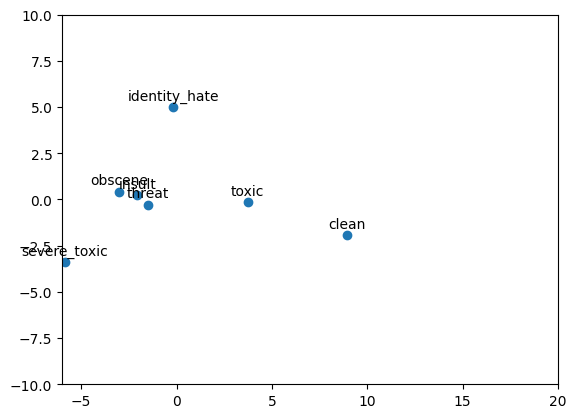

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(2)
Xt = pca.fit_transform(new_h.cpu().detach().numpy())
plot = plt.scatter(Xt[:,0], Xt[:,1])
for i, label in enumerate(labels):
    plt.annotate(label, (Xt[i][0], Xt[i][1]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.xlim(-6, 20)
plt.ylim(-10, 10)
plt.show()

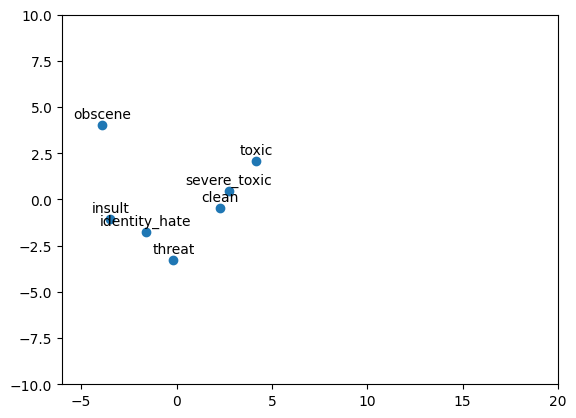

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(2)
Xt = pca.fit_transform(glove_label_embeddings)
plot = plt.scatter(Xt[:,0], Xt[:,1])
for i, label in enumerate(labels):
    plt.annotate(label, (Xt[i][0], Xt[i][1]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.xlim(-6, 20)
plt.ylim(-10, 10)
plt.show()

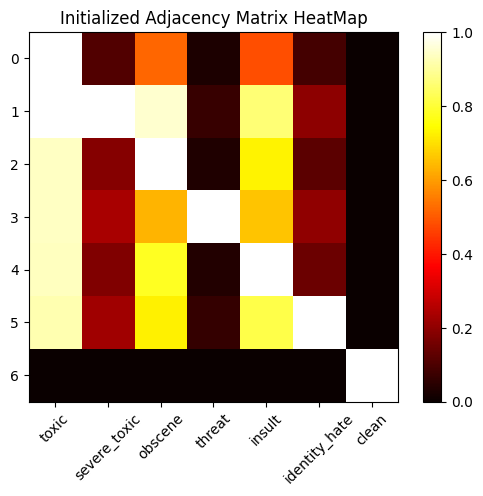

In [ ]:
plt.imshow(adj_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.title('Initialized Adjacency Matrix HeatMap')
plt.show()

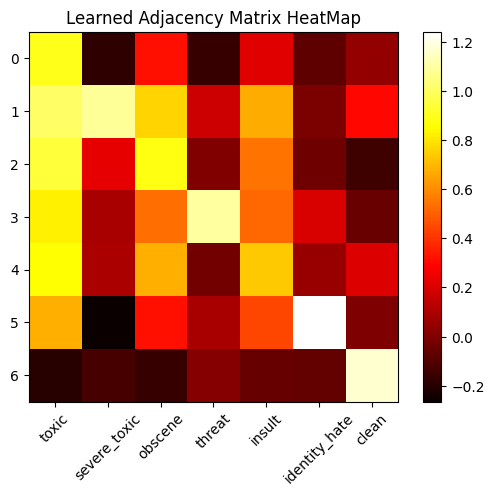

In [ ]:
plt.imshow(model.adjacency.detach().cpu().numpy(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.title('Learned Adjacency Matrix HeatMap')
plt.show()

**Summary of all the algorithms used till now (classical + DL)**

In [ ]:
scores_df

,model_name,micro_avg_f1_score,hamming_loss,accuracy
0,BR,0.76825,0.076117,0.66718
1,Classifier_Chain,0.769028,0.076451,0.672111
2,One_vs_rest,0.765692,0.076117,0.66718
3,One_vs_rest,0.765692,0.076117,0.66718
4,Hierarchical_SVM,0.776746,0.073472,0.672265
5,BiLSTM_glove,0.828584,0.075083,0.667951
6,BiLSTM_bert,0.83385,0.076097,0.68041
7,CNN_glove,0.815412,0.07867,0.657473
8,CNN_bert,0.82195,0.079621,0.67003
9,MAGNET_Cooccurance,0.79341,0.09229,0.61402


In [ ]:
train_df = pd.read_csv('train.csv')
print("Data shape:",train_df.shape)
#assigning labels

#Adding new column of Clean Text
arr=[]
for i in range(train_df.shape[0]):
  if (train_df.iloc[i,2:]==0).all():
    arr.append(1)
  else:
    arr.append(0)
train_df['clean'] = pd.Series(np.asarray(arr))
labels = train_df.columns[2:]
print("Labels:",labels)

Data shape: (159571, 8)
Labels: Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate',
       'clean'],
      dtype='object')


In [ ]:
train_df = preprocess_text(train_df)
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,daww match background colour im seemingly stuc...,0,0,0,0,0,0,1
2,000113f07ec002fd,hey man im really trying edit war guy constant...,0,0,0,0,0,0,1
3,0001b41b1c6bb37e,cant make real suggestion improvement wondered...,0,0,0,0,0,0,1
4,0001d958c54c6e35,sir hero chance remember page thats on,0,0,0,0,0,0,1


In [ ]:
#Get sampled Data by removing Rows which create Bias
train_df = sample_dataset(train_df)
train_df.head()

<ipython-input-4-ecde23a7a0f1>:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(train_df[train_df['clean']==1].sample(frac=1, random_state=200).iloc[:df.shape[0],:])


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
134065,cd04ee4935924644,got ill start on,0,0,0,0,0,0,1
128040,acd929b3f6c5984b,barnstar anti vandalism barnstar professing lo...,0,0,0,0,0,0,1
136471,da225210fb20b417,homey yo beat u up,0,0,0,1,0,0,0
112748,5b33d2be26a63953,encouraged feedback let clear bit first versio...,0,0,0,0,0,0,1
21589,38dd995c105311e6,shes insane zealot,1,0,0,0,1,0,0


In [ ]:
device = torch.device('cuda')
if torch.cuda.is_available():
    device = torch.device('cuda:0')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
train_df, test_df = train_test_split(train_df, test_size=0.2,random_state=200,stratify=train_df.iloc[:,-1])

In [ ]:
class ToxicDataset(Dataset):
    
    def __init__(self, tokenizer: BertTokenizer, dataframe: pd.DataFrame, lazy: bool = False):
        self.tokenizer = tokenizer
        self.pad_idx = tokenizer.pad_token_id
        self.lazy = lazy
        if not self.lazy:
            self.X = []
            self.Y = []
            for i, (row) in tqdm(dataframe.iterrows()):
                x, y = self.row_to_tensor(self.tokenizer, row)
                self.X.append(x)
                self.Y.append(y)
        else:
            self.df = dataframe        
    
    @staticmethod
    def row_to_tensor(tokenizer: BertTokenizer, row: pd.Series) -> Tuple[torch.LongTensor, torch.LongTensor]:
        tokens = tokenizer.encode(row["comment_text"], add_special_tokens=True)
        if len(tokens) > 120:
            tokens = tokens[:119] + [tokens[-1]]
        x = torch.LongTensor(tokens)
        y = torch.FloatTensor(row[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate","clean"]])
        return x, y
        
    
    def __len__(self):
        if self.lazy:
            return len(self.df)
        else:
            return len(self.X)

    def __getitem__(self, index: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        if not self.lazy:
            return self.X[index], self.Y[index]
        else:
            return self.row_to_tensor(self.tokenizer, self.df.iloc[index])
            

def collate_fn(batch: List[Tuple[torch.LongTensor, torch.LongTensor]], device: torch.device) \
        -> Tuple[torch.LongTensor, torch.LongTensor]:
    x, y = list(zip(*batch))
    x = pad_sequence(x, batch_first=True, padding_value=0)
    y = torch.stack(y)
    return x.to(device), y.to(device)


In [ ]:
train_dataset = ToxicDataset(tokenizer, train_df, lazy=True)
test_dataset = ToxicDataset(tokenizer, test_df, lazy=True)
collate_fn = partial(collate_fn, device=device)
BATCH_SIZE = 32
train_sampler = RandomSampler(train_dataset)
dev_sampler = RandomSampler(test_dataset)
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
dev_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=dev_sampler, collate_fn=collate_fn)

In [ ]:
class BertClassifier(nn.Module):
    
    def __init__(self, bert: BertModel, num_classes: int):
        super().__init__()
        self.bert = bert
        self.classifier = nn.Linear(bert.config.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None,
                
            labels=None):
        outputs = self.bert(input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids,
                               position_ids=position_ids,
                               head_mask=head_mask)
        cls_output = outputs[1] # batch, hidden
        cls_output = self.classifier(cls_output) # batch, 6
        cls_output = torch.sigmoid(cls_output)
        criterion = nn.BCELoss()
        loss = 0
        if labels is not None:
            loss = criterion(cls_output, labels)
        return loss, cls_output

In [ ]:
def train(model, iterator, optimizer, scheduler):
    model.train()
    total_loss = 0
    for x, y in tqdm(iterator):
        optimizer.zero_grad()
        mask = (x != 0).float()
        loss, outputs = model(x, attention_mask=mask, labels=y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    print(f"Train loss {total_loss / len(iterator)}")

In [ ]:
model = BertClassifier(BertModel.from_pretrained('bert-base-uncased'), 7).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
{'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
{'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
EPOCH_NUM = 8
# triangular learning rate, linearly grows untill half of first epoch, then linearly decays 
warmup_steps = 10 ** 3
total_steps = len(train_iterator) * EPOCH_NUM - warmup_steps
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
# scheduler = WarmupLinearSchedule(optimizer, warmup_steps=warmup_steps, t_total=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for i in range(EPOCH_NUM):
    print('=' * 50, f"EPOCH {i}", '=' * 50)
    train(model, train_iterator, optimizer, scheduler)
    # evaluate(model, dev_iterator)

================================================== EPOCH 0 ==================================================


100%|██████████| 812/812 [08:08<00:00,  1.66it/s]


Train loss 0.31736027307147757
================================================== EPOCH 1 ==================================================


100%|██████████| 812/812 [08:06<00:00,  1.67it/s]


Train loss 0.16124800353177957
================================================== EPOCH 2 ==================================================


100%|██████████| 812/812 [08:10<00:00,  1.66it/s]


Train loss 0.13076399981039646
================================================== EPOCH 3 ==================================================


100%|██████████| 812/812 [08:08<00:00,  1.66it/s]


Train loss 0.10927103324495073
================================================== EPOCH 4 ==================================================


100%|██████████| 812/812 [08:09<00:00,  1.66it/s]


Train loss 0.0929172182928202
================================================== EPOCH 5 ==================================================


100%|██████████| 812/812 [08:07<00:00,  1.66it/s]


Train loss 0.08077572518156777
================================================== EPOCH 6 ==================================================


100%|██████████| 812/812 [08:09<00:00,  1.66it/s]


Train loss 0.07278126178382727
================================================== EPOCH 7 ==================================================


100%|██████████| 812/812 [08:08<00:00,  1.66it/s]

Train loss 0.07109613822809802


In [ ]:
model.eval()
y_pred=[]
columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','clean']
for i in tqdm(range(len(test_df) // BATCH_SIZE + 1)):
    batch_df = test_df.iloc[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]
    texts = []
    for text in batch_df["comment_text"].tolist():
        text = tokenizer.encode(text, add_special_tokens=True)
        if len(text) > 120:
            text = text[:119] + [tokenizer.sep_token_id]
        texts.append(torch.LongTensor(text))
    x = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id).to(device)
    mask = (x != tokenizer.pad_token_id).float().to(device)
    with torch.no_grad():
        _, outputs = model(x, attention_mask=mask)
    outputs = outputs.cpu().numpy()
    y_pred.append(outputs)

100%|██████████| 203/203 [00:43<00:00,  4.72it/s]


In [ ]:
y_pred = np.vstack(np.asarray(y_pred))

<ipython-input-73-c5eb8d659cd7>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_pred = np.vstack(np.asarray(y_pred))


In [ ]:
y_pred = np.where(y_pred>0.5,1,0)

In [ ]:
y_test = test_df.iloc[:,2:].values

In [ ]:
arr={'model_name':'BERT','micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),'hamming_loss':hamming_loss(y_test, y_pred),'accuracy':accuracy_score(y_test,y_pred)}
print(arr)
print(classification_report(y_pred,y_test,zero_division=0))

{'model_name': 'BERT', 'micro_avg_f1_score': 0.8586138229151489, 'hamming_loss': 0.06407660136473696, 'accuracy': 0.700462249614792}
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      3237
           1       0.47      0.55      0.51       247
           2       0.85      0.83      0.84      1751
           3       0.48      0.67      0.56        76
           4       0.76      0.74      0.75      1600
           5       0.56      0.56      0.56       266
           6       0.93      0.94      0.93      3191

   micro avg       0.86      0.85      0.86     10368
   macro avg       0.71      0.74      0.72     10368
weighted avg       0.87      0.85      0.86     10368
 samples avg       0.88      0.86      0.85     10368



# Second dataset

For this dataset as well, we perform similar preprocessing which is shown below.

In [ ]:
# Load the dataset and extract the documents and labels
import nltk

nltk.download('reuters')
docs = nltk.corpus.reuters.fileids()
labels = [nltk.corpus.reuters.categories(doc) for doc in docs]
texts = [nltk.corpus.reuters.raw(doc) for doc in docs]
mlb = MultiLabelBinarizer()
bin_labels = mlb.fit_transform(labels)
label_names = mlb.classes_

[nltk_data] Downloading package reuters to /root/nltk_data...


In [ ]:
df = pd.DataFrame({'text': texts})
for i, label in enumerate(label_names):
    df[label] = bin_labels[:, i]

print(df.head())
labels = df.columns[1:]
X_train = df['text']
# X_test = test_df['comment_text']
y_train = df.iloc[:,1:]

                                                text  acq  alum  barley  bop  \
0  ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...    0     0       0    0   
1  CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...    0     0       0    0   
2  JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...    0     0       0    0   
3  THAI TRADE DEFICIT WIDENS IN FIRST QUARTER\n  ...    0     0       0    0   
4  INDONESIA SEES CPO PRICE RISING SHARPLY\n  Ind...    0     0       0    0   

   carcass  castor-oil  cocoa  coconut  coconut-oil  ...  sun-oil  sunseed  \
0        0           0      0        0            0  ...        0        0   
1        0           0      0        0            0  ...        0        0   
2        0           0      0        0            0  ...        0        0   
3        0           0      0        0            0  ...        0        0   
4        0           0      0        0            0  ...        0        0   

   tea  tin  trade  veg-oil  wheat  wpi  yen  zinc

In [ ]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].apply(cleanHtml)
df['text'] = df['text'].apply(cleanPunc)
df['text'] = df['text'].apply(keepAlpha)
df['text'] = df['text'].apply(removeStopWords)
df['text'] = df['text'].apply(lemmatize)

df.head()

,text,acq,alum,barley,bop,carcass,castor-oil,cocoa,coconut,coconut-oil,...,sun-oil,sunseed,tea,tin,trade,veg-oil,wheat,wpi,yen,zinc
0,asian exporter fear damage u japan rift mounti...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,china daily say vermin eat pct grain stock sur...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,japan revise long term energy demand downwards...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,thai trade deficit widens first quarter thaila...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,indonesia see cpo price rising sharply indones...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


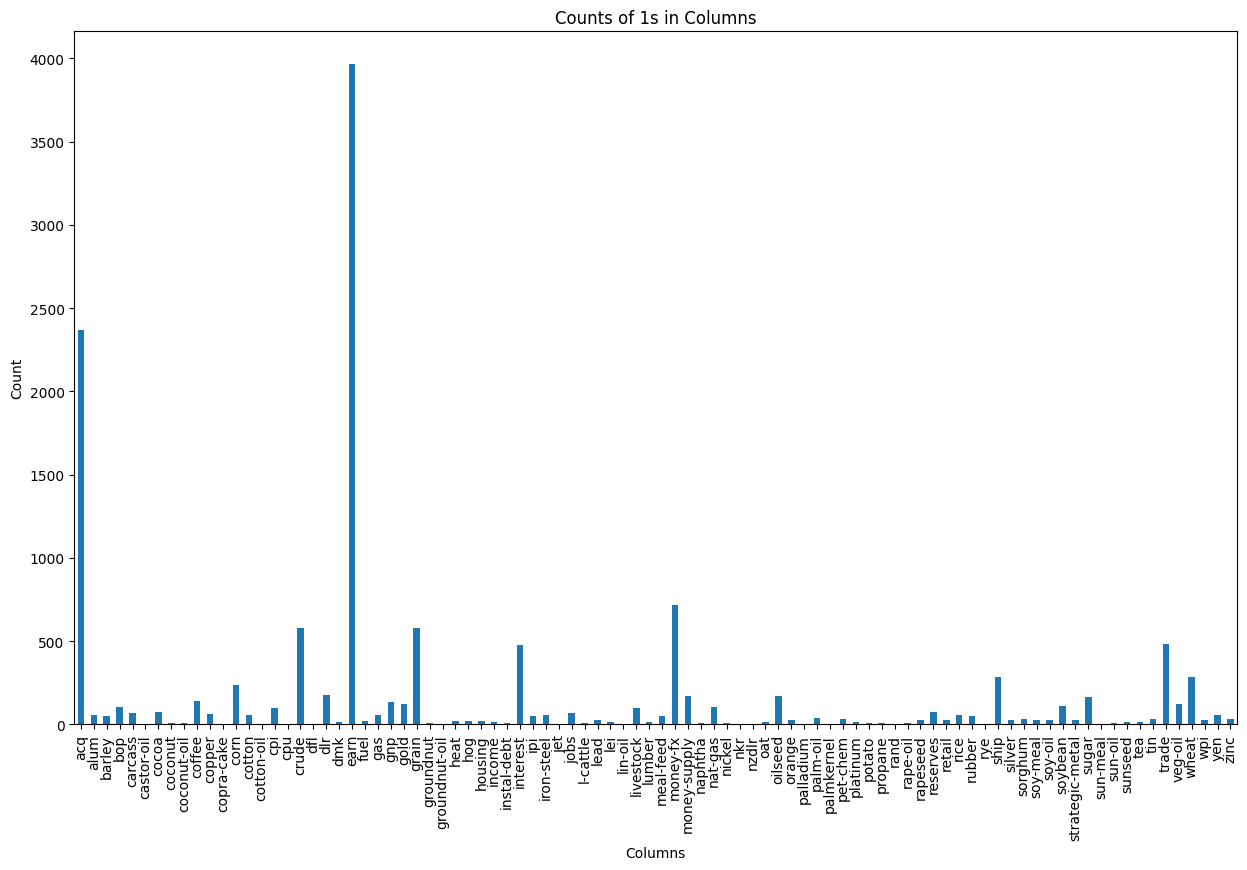

In [ ]:
# filter the DataFrame to include only numeric columns
numeric_df = df.select_dtypes(include=['int', 'float'])
# count the number of 1's in each column
counts = numeric_df.sum()
# create a bar chart of the counts with a larger figure size
fig = plt.figure(figsize=(15, 9))
counts.plot(kind='bar')
# add chart labels
plt.title('Counts of 1s in Columns')
plt.xlabel('Columns')
plt.ylabel('Count')
# display the chart
plt.show()

Preparing training data for classical ML algorithms

In [ ]:
X = df['text'].values
y = df.iloc[:,1:].values
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=200)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )
#ML preprocessing

word_vectorizer = TfidfVectorizer(
    strip_accents='unicode',     
    analyzer='word',
    max_features=3000,        
    token_pattern=r'\w{1,}',    
    ngram_range=(1, 3),         
    stop_words='english',
    sublinear_tf=True)

word_vectorizer.fit(X_train)
ml_X_train = word_vectorizer.transform(X_train)
ml_X_test = word_vectorizer.transform(X_test)

print(ml_X_train.shape, ml_X_test.shape)

(10788,) (10788, 90)
(8630,) (2158,) (8630, 90) (2158, 90)
(8630, 3000) (2158, 3000)


In [ ]:
scores_df = pd.DataFrame(columns=['model_name','micro_avg_f1_score','hamming_loss','accuracy'])

In [ ]:
model = BinaryRelevance(LogisticRegression(solver='sag'))
model.fit(ml_X_train, y_train)
y_pred = model.predict(ml_X_test)
arr={'model_name':'BR','micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),'hamming_loss':hamming_loss(y_test, y_pred),'accuracy':accuracy_score(y_test,y_pred)}
scores_df = scores_df.append(arr,ignore_index=True)
print(classification_report(y_pred,y_test, zero_division=0))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       463
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.40      1.00      0.57         8
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.20      1.00      0.33         2
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.50      1.00      0.67        15
          10       0.08      1.00      0.15         1
          11       0.00      0.00      0.00         0
          12       0.42      1.00      0.59        22
          13       0.11      1.00      0.20         1
          14       0.00      0.00      0.00         0
          15       0.47      1.00      0.64         7
          16       0.00      0.00      0.00         0
          17       0.73    

<ipython-input-142-ba6a06d0e02b>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(arr,ignore_index=True)


In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Set the warning filter to ignore ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

model = ClassifierChain(LogisticRegression(solver='sag', max_iter=1000))
model.fit(ml_X_train, y_train)
y_pred = model.predict(ml_X_test)
arr={'model_name':'Classifier_Chain','micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),'hamming_loss':hamming_loss(y_test, y_pred),'accuracy':accuracy_score(y_test,y_pred)}

scores_df = scores_df.append(arr,ignore_index=True)
print(classification_report(y_pred,y_test,zero_division=0))

# Reset the warning filter to its default behavior
warnings.filterwarnings('default', category=ConvergenceWarning)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       463
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.40      1.00      0.57         8
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.20      1.00      0.33         2
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.50      1.00      0.67        15
          10       0.08      1.00      0.15         1
          11       0.00      0.00      0.00         0
          12       0.35      1.00      0.51        18
          13       0.11      1.00      0.20         1
          14       0.00      0.00      0.00         0
          15       0.47      1.00      0.64         7
          16       0.00      0.00      0.00         0
          17       0.72    

<ipython-input-143-0040459b4f27>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(arr,ignore_index=True)


In [ ]:
model = LabelPowerset(LogisticRegression(max_iter=1000))
model.fit(ml_X_train, y_train)
y_pred = model.predict(ml_X_test)
arr={'model_name':'Label_Powerset Chain','micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),'hamming_loss':hamming_loss(y_test, y_pred),'accuracy':accuracy_score(y_test,y_pred)}
scores_df = scores_df.append(arr,ignore_index=True)
print(classification_report(y_pred,y_test,zero_division=0))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90       564
           1       0.38      0.83      0.53         6
           2       0.00      0.00      0.00         0
           3       0.60      0.92      0.73        13
           4       0.33      0.67      0.44         3
           5       0.00      0.00      0.00         0
           6       0.80      1.00      0.89         8
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.80      1.00      0.89        24
          10       0.58      1.00      0.74         7
          11       0.00      0.00      0.00         0
          12       0.48      1.00      0.65        25
          13       0.56      1.00      0.71         5
          14       0.00      0.00      0.00         0
          15       0.80      0.71      0.75        17
          16       0.00      0.00      0.00         0
          17       0.82    

<ipython-input-144-a377907869e2>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(arr,ignore_index=True)


In [ ]:
scores_df

,model_name,micro_avg_f1_score,hamming_loss,accuracy
0,BR,0.800178,0.004634,0.709917
1,Classifier_Chain,0.812240,0.004423,0.736330
2,Label_Powerset Chain,0.831524,0.004315,0.812790


In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,random_state=200)
#DL preprocessing

tokenizer = Tokenizer(num_words=20000,oov_token='<UNK>')
tokenizer.fit_on_texts(X_train)
sequences_text_train = tokenizer.texts_to_sequences(X_train)
sequences_text_test = tokenizer.texts_to_sequences(X_test)

X_train = torch.from_numpy(pad_sequences(sequences_text_train, maxlen=70))
X_test = torch.from_numpy(pad_sequences(sequences_text_test, maxlen=70))

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )
print(len(tokenizer.index_word))

torch.Size([8630, 70]) torch.Size([2158, 70]) torch.Size([8630, 90]) torch.Size([2158, 90])
24610


In [ ]:
#Load glove embedding
glove_embeddings = {}
with open('glove.6B/glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.split()
        word = parts[0]
        vector = np.array(parts[1:], dtype=np.float32)
        glove_embeddings[word] = vector

VOCAB_SIZE = len(tokenizer.index_word)+1
glove_embedding_matrix = torch.zeros(VOCAB_SIZE, 300)

unk = 0
for i in range(1, VOCAB_SIZE):
  word = tokenizer.index_word[i]
  if word in glove_embeddings.keys():
    glove_embedding_matrix[i] = torch.from_numpy(glove_embeddings[word]).float()
  else:
    unk +=1
print('VOCAB_SIZE : {}'.format(VOCAB_SIZE))
print('TOTAL OF UNKNOWN WORD : {}'.format(unk))

VOCAB_SIZE : 24611
TOTAL OF UNKNOWN WORD : 4653


In [ ]:
class MLP_Glove(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP_Glove, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(glove_embedding_matrix)
        self.fc1 = nn.Linear(300, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedding = self.embedding(x)
        out = torch.mean(embedding,dim=1)
        out = self.relu(self.fc1(out))
        out = self.sigmoid(self.fc2(out))
        return out

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
device = torch.device('cuda')

In [ ]:
model = MLP_Glove(70, 300, 90).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Generate dummy input and target data

num_epochs = 100
for epoch in range(num_epochs):
    total_loss=0
    for i,(inputs, targets) in enumerate(train_dataloader):
        # Forward pass
        # inputs = inputs.to(next(model.parameters()).dtype)
        # targets = targets.to(model.device)
        output = model(inputs.to(device))
        # print(output)
        targets = targets.float().to(device)
        
        # Compute loss
        loss = criterion(output, targets).to(device)
        total_loss+=loss.item()
        
        # Backward pass and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Print loss every 10 epochs
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, total_loss/256))

Epoch [1/100], Loss: 0.6476
Epoch [2/100], Loss: 0.6304
Epoch [3/100], Loss: 0.6286
Epoch [4/100], Loss: 0.6283
Epoch [5/100], Loss: 0.6273
Epoch [6/100], Loss: 0.6265
Epoch [7/100], Loss: 0.6261
Epoch [8/100], Loss: 0.6242
Epoch [9/100], Loss: 0.6235
Epoch [10/100], Loss: 0.6208
Epoch [11/100], Loss: 0.6173
Epoch [12/100], Loss: 0.6150
Epoch [13/100], Loss: 0.6133
Epoch [14/100], Loss: 0.6124
Epoch [15/100], Loss: 0.6116
Epoch [16/100], Loss: 0.6097
Epoch [17/100], Loss: 0.6087
Epoch [18/100], Loss: 0.6059
Epoch [19/100], Loss: 0.6042
Epoch [20/100], Loss: 0.6024
Epoch [21/100], Loss: 0.6006
Epoch [22/100], Loss: 0.6002
Epoch [23/100], Loss: 0.5996
Epoch [24/100], Loss: 0.5995
Epoch [25/100], Loss: 0.5990
Epoch [26/100], Loss: 0.5986
Epoch [27/100], Loss: 0.5983
Epoch [28/100], Loss: 0.5984
Epoch [29/100], Loss: 0.5979
Epoch [30/100], Loss: 0.5977
Epoch [31/100], Loss: 0.5977
Epoch [32/100], Loss: 0.5970
Epoch [33/100], Loss: 0.5975
Epoch [34/100], Loss: 0.5970
Epoch [35/100], Loss: 0

In [ ]:
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True)

In [ ]:
y_pred = []
for i,(inputs, targets) in enumerate(test_dataloader):
      # Forward pass
      inputs = inputs.to(device)
      targets = targets.to(device)
      output = model(inputs).detach()
      for j in output:
        y_pred.append(j.cpu().numpy())

# y_test.numpy()
y_pred = np.vstack(y_pred)
y_pred = np.where(y_pred>0.5,1,0)

In [ ]:
arr={'model_name':'MLP_Glove','micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),'hamming_loss':hamming_loss(y_test, y_pred),'accuracy':accuracy_score(y_test,y_pred)}
scores_df = scores_df.append(arr,ignore_index=True)
print(classification_report(y_pred,y_test,zero_division=0))

              precision    recall  f1-score   support

           0       0.27      0.22      0.25       580
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        52
           4       0.00      0.00      0.00        19
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00        26
          10       0.00      0.00      0.00        41
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00        84
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00        30
          16       0.00      0.00      0.00         0
          17       0.08    

<ipython-input-153-e48a89fd9cc8>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(arr,ignore_index=True)


In [ ]:
import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
keras.backend.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [ ]:
embd_mat= np.array(glove_embedding_matrix.to('cpu'))
embd_mat = np.vstack((np.zeros((1, embd_mat.shape[1])), embd_mat))

### Running deep learning algorithms

The algorithms used are - 
* BiLSTM using glove embeddings
* BiLSTM using BERT embeddings
* CNN using BERT embeddings
* CNN usin BERT embeddings

In [ ]:
print("=====================Glove BiLSTM===========================")
inp = Input(shape=(70,))
x = Embedding(VOCAB_SIZE+1, 300, weights=[embd_mat])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(90, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(np.asarray(X_train),np.asarray(y_train), batch_size=256, epochs=40)
y_pred = model.predict(np.asarray(X_test),batch_size=256, verbose=1)
y_pred= np.where(y_pred > 0.5, 1, 0)

arr={'model_name':'BiLSTM_glove','micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),'hamming_loss':hamming_loss(y_test, y_pred),'accuracy':accuracy_score(y_test,y_pred)}
scores_df = scores_df.append(arr,ignore_index=True)
print(scores_df)
print(classification_report(y_pred,y_test))

=====================Glove BiLSTM===========================
Epoch 1/40
34/34 [==============================] - 34s 781ms/step - loss: 0.4786 - accuracy: 0.0787
Epoch 2/40
34/34 [==============================] - 27s 783ms/step - loss: 0.0861 - accuracy: 0.2504
Epoch 3/40
34/34 [==============================] - 27s 796ms/step - loss: 0.0553 - accuracy: 0.3308
Epoch 4/40
34/34 [==============================] - 26s 762ms/step - loss: 0.0532 - accuracy: 0.3468
Epoch 5/40
34/34 [==============================] - 26s 759ms/step - loss: 0.0513 - accuracy: 0.3762
Epoch 6/40
34/34 [==============================] - 24s 716ms/step - loss: 0.0492 - accuracy: 0.4168
Epoch 7/40
34/34 [==============================] - 24s 707ms/step - loss: 0.0467 - accuracy: 0.4590
Epoch 8/40
34/34 [==============================] - 23s 690ms/step - loss: 0.0438 - accuracy: 0.5023
Epoch 9/40
34/34 [==============================] - 24s 690ms/step - loss: 0.0407 - accuracy: 0.5378
Epoch 10/40
34/34 [===========

<ipython-input-163-d570d8fba6df>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(arr,ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0

In [ ]:
print("=====================Bert BiLSTM===========================")
inp = Input(shape=(70,))
x = Embedding(VOCAB_SIZE, 768, weights=[bert_embd_mat])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(7, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(np.asarray(X_train),np.asarray(y_train), batch_size=256, epochs=4)
y_pred = model.predict(np.asarray(X_test),batch_size=256, verbose=1)
y_pred= np.where(y_pred > 0.5, 1, 0)

arr={'model_name':'BiLSTM_bert','micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),'hamming_loss':hamming_loss(y_test, y_pred),'accuracy':accuracy_score(y_test,y_pred)}
scores_df = scores_df.append(arr,ignore_index=True)
print(scores_df)
print(classification_report(y_pred,y_test))

In [ ]:
print("=====================Glove CNN===========================")
inp = Input(shape=(70,))

x = Embedding(VOCAB_SIZE+1, 300, weights=[embd_mat])(inp)
x = layers.Conv1D(filters=128, kernel_size=5, activation='relu')(x)
x = GlobalMaxPool1D()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)
x = Dense(90, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(np.asarray(X_train),np.asarray(y_train), batch_size=256, epochs=50)
y_pred = model.predict(np.asarray(X_test),batch_size=256, verbose=1)
y_pred= np.where(y_pred > 0.5, 1, 0)

arr={'model_name':'CNN_glove','micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),'hamming_loss':hamming_loss(y_test, y_pred),'accuracy':accuracy_score(y_test,y_pred)}
scores_df = scores_df.append(arr,ignore_index=True)
print(scores_df)
print(classification_report(y_pred,y_test))


=====================Glove CNN===========================
Epoch 1/50
34/34 [==============================] - 14s 290ms/step - loss: 0.4044 - accuracy: 0.0090
Epoch 2/50
34/34 [==============================] - 6s 172ms/step - loss: 0.0594 - accuracy: 0.3910
Epoch 3/50
34/34 [==============================] - 7s 193ms/step - loss: 0.0409 - accuracy: 0.5372
Epoch 4/50
34/34 [==============================] - 5s 157ms/step - loss: 0.0360 - accuracy: 0.5767
Epoch 5/50
34/34 [==============================] - 4s 122ms/step - loss: 0.0322 - accuracy: 0.6249
Epoch 6/50
34/34 [==============================] - 5s 133ms/step - loss: 0.0289 - accuracy: 0.6592
Epoch 7/50
34/34 [==============================] - 5s 133ms/step - loss: 0.0255 - accuracy: 0.6903
Epoch 8/50
34/34 [==============================] - 3s 102ms/step - loss: 0.0224 - accuracy: 0.7229
Epoch 9/50
34/34 [==============================] - 3s 89ms/step - loss: 0.0200 - accuracy: 0.7502
Epoch 10/50
34/34 [=======================

<ipython-input-167-14bdbcadc155>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append(arr,ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0

In [ ]:
print("=====================Bert CNN===========================")
inp = Input(shape=(max_seq_len,))

x = Embedding(VOCAB_SIZE, 768, weights=[bert_embd_mat])(inp)
x = layers.Conv1D(filters=128, kernel_size=5, activation='relu')(x)
x = GlobalMaxPool1D()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)
x = Dense(7, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(np.asarray(X_train),np.asarray(y_train), batch_size=256, epochs=3)
y_pred = model.predict(np.asarray(X_test),batch_size=256, verbose=1)
y_pred= np.where(y_pred > 0.5, 1, 0)

arr={'model_name':'CNN_bert','micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),'hamming_loss':hamming_loss(y_test, y_pred),'accuracy':accuracy_score(y_test,y_pred)}
scores_df = scores_df.append(arr,ignore_index=True)
print(scores_df)
print(classification_report(y_pred,y_test))


In [ ]:
adj_matrix = create_adjacency_matrix_cooccurance(y_train.numpy())
adj_matrix = torch.tensor(adj_matrix)
adj_matrix

In [ ]:
save_path = './train_result.pt'

In [ ]:
glove_label_embedding = torch.zeros(len(labels),300)

for index, label in enumerate(labels):
  wrds = label.split('-')
  for l in wrds:
    if l in glove_embeddings.keys():
        glove_label_embedding[index] +=  torch.from_numpy(glove_embeddings[l])
  glove_label_embedding[index]=glove_label_embedding[index]/len(wrds)  

print(glove_label_embedding)

In [ ]:
model = MAGNET(300, 250, adj_matrix, glove_embedding_matrix,heads=8)
train(model, X_train, glove_label_embedding,y_train,total_epoch=15, save_path=save_path)